In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import prep

import warnings
warnings.filterwarnings("ignore")

In [2]:
store = prep.prep_zach()
store

,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,day,month,sales_total
sale_date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,1,10.92
2013-01-02 00:00:00+00:00,1,11.0,2,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Wednesday,1,9.24
2013-01-03 00:00:00+00:00,1,14.0,3,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Thursday,1,11.76
2013-01-04 00:00:00+00:00,1,13.0,4,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Friday,1,10.92
2013-01-05 00:00:00+00:00,1,10.0,5,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Saturday,1,8.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27 00:00:00+00:00,50,63.0,912996,10,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Wednesday,12,327.60
2017-12-28 00:00:00+00:00,50,59.0,912997,10,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Thursday,12,306.80
2017-12-29 00:00:00+00:00,50,74.0,912998,10,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Friday,12,384.80


In [3]:
store['Year'] = store.index.year
store.Year.unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int64)

In [4]:
# Since our data is cyclical, we will use the human method to split our date into train, validate, and test 
# split using full years 
train = store[store['Year'] < 2016]
validate = store[store['Year'] == 2016]
test = store[store['Year'] == 2017]

# Resample the data by month and sum the traget variable
train = train[['sale_amount', 'sales_total']].resample('M').sum()
validate = validate[['sale_amount', 'sales_total']].resample('M').sum()
test = test[['sale_amount', 'sales_total']].resample('M').sum()

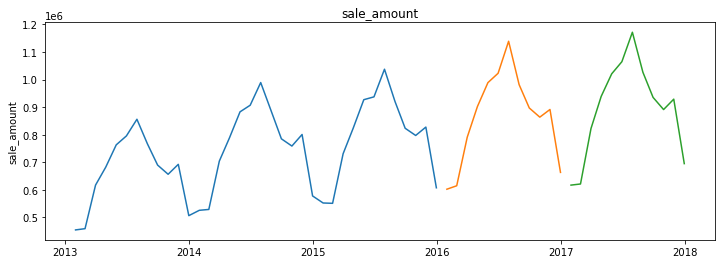

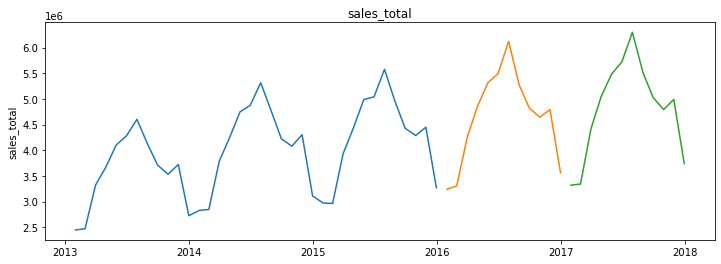

In [5]:
columns = ['sale_amount', 'sales_total']

for col in columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [6]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

eval_df

,model_type,target_var,rmse


In [7]:
items = train['sale_amount'][-1:][0]
dollars = round(train['sales_total'][-1:][0],2)

yhat_df = pd.DataFrame({'sale_amount': [items], 'sales_total': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,sale_amount,sales_total
sale_date,,
2016-01-31 00:00:00+00:00,607572.0,3268736.22
2016-02-29 00:00:00+00:00,607572.0,3268736.22


sale_amount -- RMSE: 301773


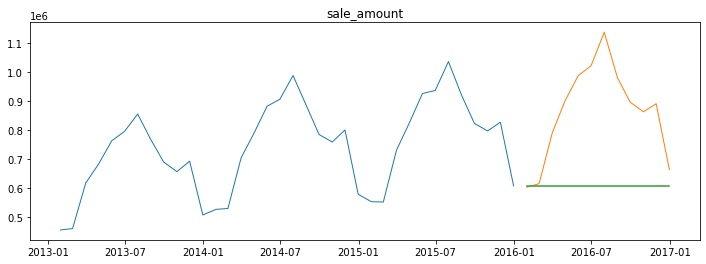

sales_total -- RMSE: 1620001


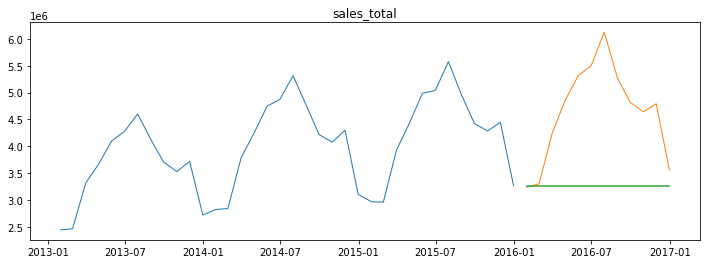

In [8]:
for col in train.columns:
    plot_and_eval(col)

In [9]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,301773.0
1,last_observed_value,sales_total,1620001.0


In [10]:
items = round(train['sale_amount'].mean(), 2)
dollars = round(train['sales_total'].mean(), 2)

items = round(train['sale_amount'].mean(), 2)
dollars = round(train['sales_total'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'sale_amount': [items],
                            'sales_total': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head(2)

,sale_amount,sales_total
sale_date,,
2016-01-31 00:00:00+00:00,739267.0,3974693.29
2016-02-29 00:00:00+00:00,739267.0,3974693.29


sale_amount -- RMSE: 202750


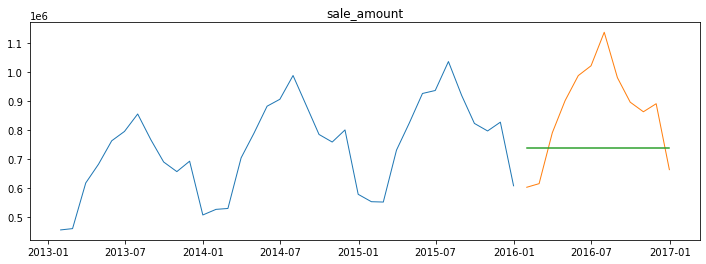

sales_total -- RMSE: 1089633


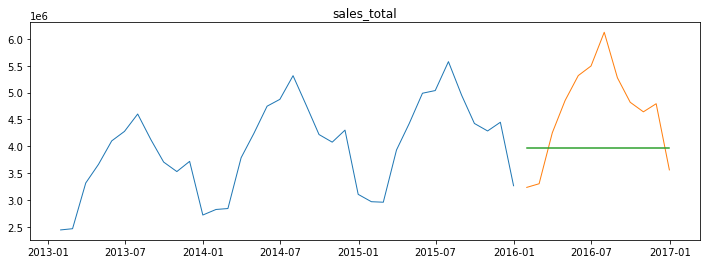

In [11]:
for col in train.columns:
    plot_and_eval(col)

In [12]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)


In [13]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,301773.0
1,last_observed_value,sales_total,1620001.0
2,simple_average,sale_amount,202750.0
3,simple_average,sales_total,1089633.0


In [14]:
# Do a 3 month rolling average

period = 3

items = round(train['sale_amount'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['sales_total'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,sale_amount,sales_total
sale_date,,
2016-01-31 00:00:00+00:00,744156.67,4001450.1
2016-02-29 00:00:00+00:00,744156.67,4001450.1
2016-03-31 00:00:00+00:00,744156.67,4001450.1


sale_amount -- RMSE: 199802


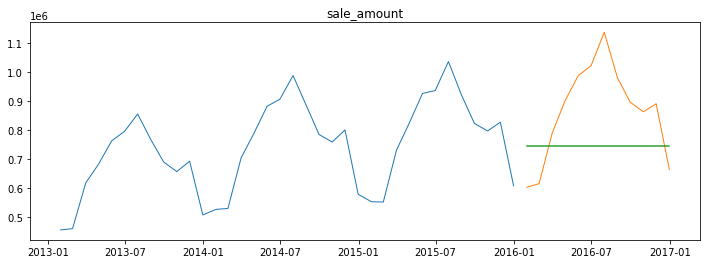

sales_total -- RMSE: 1073516


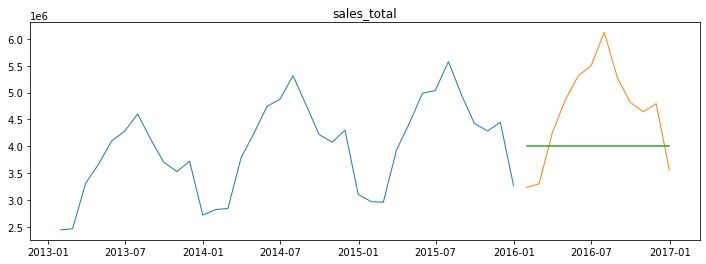

In [15]:
for col in train.columns:
    plot_and_eval(col)

In [16]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3month moving average', 
                             target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,301773.0
1,last_observed_value,sales_total,1620001.0
2,simple_average,sale_amount,202750.0
3,simple_average,sales_total,1089633.0
4,3month moving average,sale_amount,199802.0
5,3month moving average,sales_total,1073516.0


In [17]:
eval_df.replace(to_replace='30d moving average', value='4month moving average', inplace=True)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,301773.0
1,last_observed_value,sales_total,1620001.0
2,simple_average,sale_amount,202750.0
3,simple_average,sales_total,1089633.0
4,3month moving average,sale_amount,199802.0
5,3month moving average,sales_total,1073516.0


In [18]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
4,3month moving average,sale_amount,199802.0
5,3month moving average,sales_total,1073516.0


sale_amount 



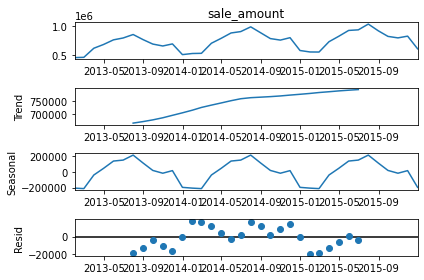

sales_total 



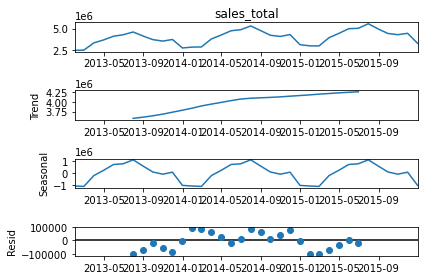

In [19]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [20]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

sale_amount -- RMSE: 161187


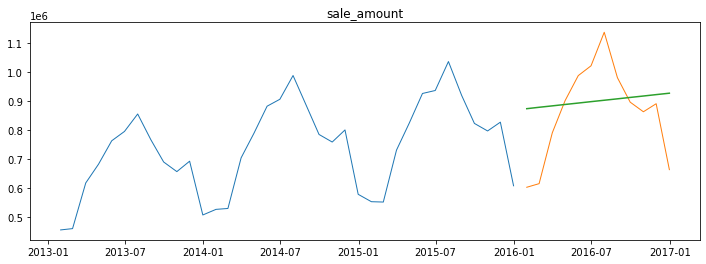

sales_total -- RMSE: 867272


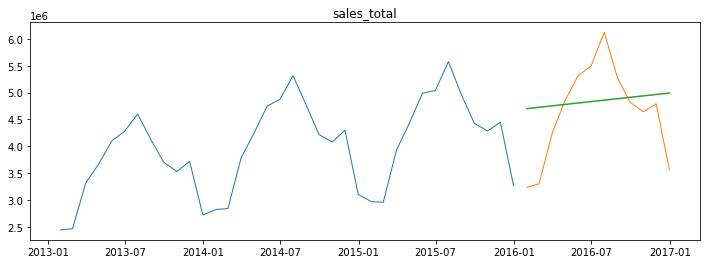

In [21]:
for col in train.columns:
    plot_and_eval(target_var = col)
    


In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,301773.0
1,last_observed_value,sales_total,1620001.0
2,simple_average,sale_amount,202750.0
3,simple_average,sales_total,1089633.0
4,3month moving average,sale_amount,199802.0
5,3month moving average,sales_total,1073516.0
6,Holts,sale_amount,161187.0
7,Holts,sales_total,867272.0


In [23]:
yhat_df = train['2015'] + train.diff(3).mean()

pd.concat([yhat_df.head(1), validate.head(1)])
len(yhat_df)

12

sale_amount -- RMSE: 49029


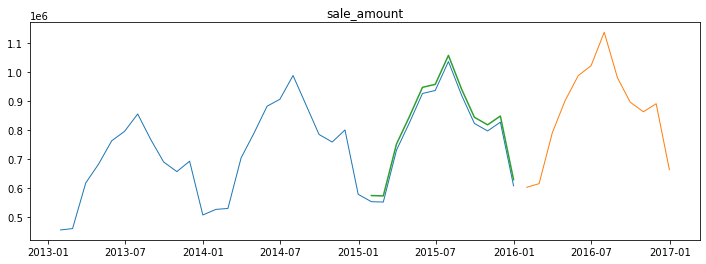

sales_total -- RMSE: 263051


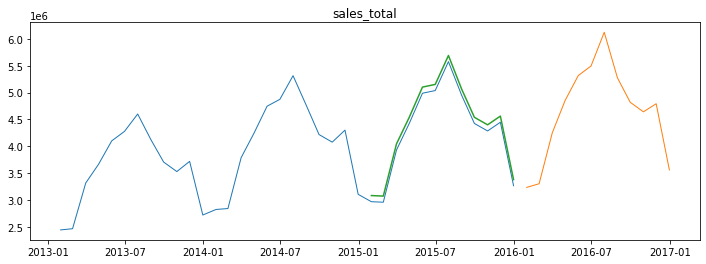

In [24]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous 3 months', target_var = col)

In [25]:
min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]


,model_type,target_var,rmse
8,previous 3 months,sale_amount,49029.0
9,previous 3 months,sales_total,263051.0


In [26]:
eval_df.replace(to_replace='previous year', value='previous 4 months', inplace=True)

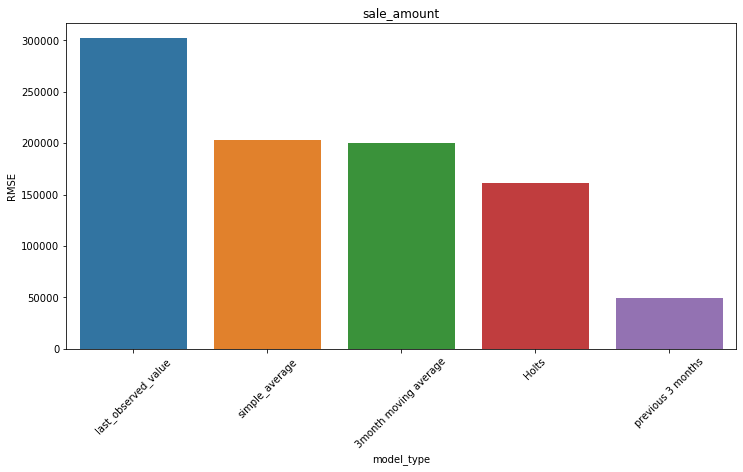

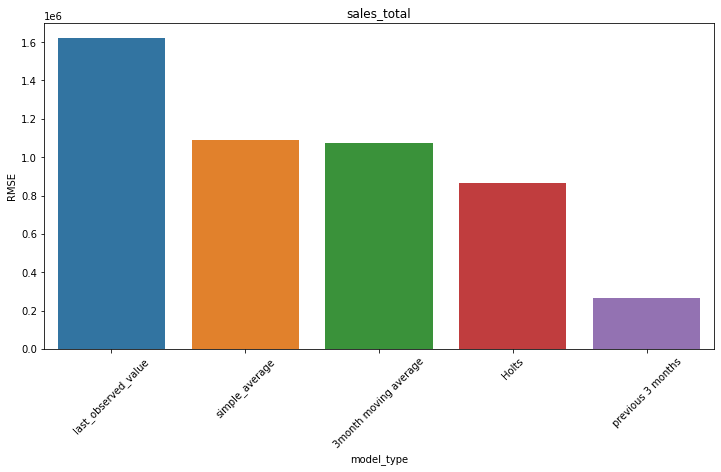

In [27]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [28]:
yhat_df = validate + train.diff(4).mean()
yhat_df.index = test.index

rmse_dollars = round(sqrt(mean_squared_error(test['sales_total'], yhat_df['sales_total'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['sale_amount'], yhat_df['sale_amount'])), 0)

In [34]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], label='Prediction', alpha = .5)
    plt.title(target_var)
    plt.legend()
    plt.show()

rmse - sales_total:  62246.0
rmse - sale_amount:  11668.0


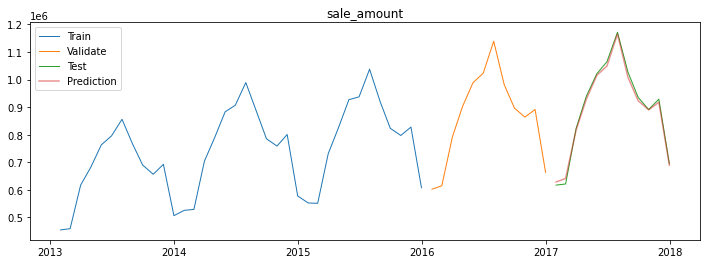

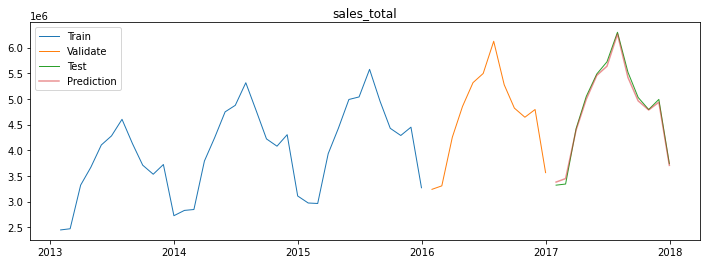

In [35]:
print("rmse - sales_total: ", rmse_dollars)
print("rmse - sale_amount: ", rmse_items)

for col in train.columns:
    plot_and_eval(col)